# Menginstall Dependency

In [ ]:
!pip install "pyarrow==19.0.0" --force-reinstall -q
!pip install -U datasets bitsandbytes sentencepiece -q
!pip install -U "transformers>=4.44.0" "accelerate>=0.34.0" "peft>=0.11.0" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.0 which is incompatible.


# Import Library

In [ ]:
import os
import glob
from google.colab import drive
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model

# Mount Google Drive

In [ ]:
drive.mount('/content/drive')
LOCAL_DATA_DIR = "/content/drive/MyDrive/pdf_files/cleaned_txt"
# LOCAL_DATA_DIR = "/content/drive/MyDrive/PRD-Sumber1-JudiOnline_clean.txt"

Mounted at /content/drive


# Konfigurasi Global & Pemuatan Data

In [ ]:
MODEL_NAME = "Qwen/Qwen3-0.6B"
BLOCK_SIZE = 512

all_files = glob.glob(os.path.join(LOCAL_DATA_DIR, "*.txt"))
# all_files = [LOCAL_DATA_DIR]
print(f"Total file.txt yang ditemukan: {len(all_files)}")

if not all_files:
    raise ValueError(f"Tidak ada file.txt yang ditemukan di {LOCAL_DATA_DIR}. Periksa path dan proses unzip.")

raw_dataset = load_dataset("text", data_files=all_files, split="train")

Total file.txt yang ditemukan: 114


Resolving data files:   0%|          | 0/114 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Split Dataset

In [ ]:
print("Memisahkan dataset 90:10...")
split_dataset = raw_dataset.train_test_split(test_size=0.1, seed=42)
dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': split_dataset['test']
})
print(dataset)

Memisahkan dataset 90:10...
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 700
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 78
    })
})


# Tokenisasi

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    return tokenizer(examples["text"], add_special_tokens=True, truncation=False)

print("Menjalankan tokenisasi...")
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=["text"]
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Menjalankan tokenisasi...


Map (num_proc=4):   0%|          | 0/700 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/78 [00:00<?, ? examples/s]

# Chunking

In [ ]:
def group_texts(examples):
  # Concatenate
  concatenated = {k: sum(examples[k], []) for k in examples.keys()}
  total_length = len(concatenated[list(examples.keys())[0]])

  # Trimming
  if total_length >= BLOCK_SIZE:
      total_length = (total_length // BLOCK_SIZE) * BLOCK_SIZE

  # Chunking
  result = {
      k: [t[i : i + BLOCK_SIZE] for i in range(0, total_length, BLOCK_SIZE)]
      for k, t in concatenated.items()
  }

  result["labels"] = result["input_ids"].copy()
  return result


print("Mengelompokkan teks menjadi blok-blok...")
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=4,
)
print(f"Contoh data yang telah diproses: {lm_datasets['train']}")

Mengelompokkan teks menjadi blok-blok...


Map (num_proc=4):   0%|          | 0/700 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/78 [00:00<?, ? examples/s]

Contoh data yang telah diproses: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1481
})


# Inisialisasi

## Load Base Model

In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=quant_config,
)

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
print(base_model)

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear8bitLt(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear8bitLt(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear8bitLt(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear8bitLt(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((1024,)

## Konfigurasi Lora

In [ ]:
lora_config = LoraConfig(
    r=6,
    lora_alpha=12,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.4,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

trainable params: 3,784,704 || all params: 599,834,624 || trainable%: 0.6310


## Data Collator

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Metrics Callback

## Callback untuk menyimpan semua metrik (train/eval, loss/perplexity)

In [ ]:
import math
from transformers import TrainerCallback

class MetricsCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.metrics = {
            'train_loss': [],
            'train_perplexity': [],
            'eval_loss': [],
            'eval_perplexity': []
        }

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and 'loss' in logs:
            step = state.global_step
            loss = logs['loss']
            self.metrics['train_loss'].append((step, loss))

            try:
                ppl = math.exp(loss)
                self.metrics['train_perplexity'].append((step, ppl))
            except OverflowError:
                self.metrics['train_perplexity'].append((step, float('inf')))

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None and 'eval_loss' in metrics:
            step = state.global_step
            loss = metrics['eval_loss']
            self.metrics['eval_loss'].append((step, loss))

            try:
                ppl = math.exp(loss)
                self.metrics['eval_perplexity'].append((step, ppl))
            except OverflowError:
                self.metrics['eval_perplexity'].append((step, float('inf')))

metrics_callback = MetricsCallback()

# Setup Up Monitoring WANDB

In [ ]:
import wandb
from dotenv import load_dotenv

env_path = '/content/drive/MyDrive/secrets/.env'
load_dotenv(env_path)
wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key)
wandb.init(project="CPT", name="qwen-0.6B")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: taqiyudinmiftah-02 (taqiyudinmiftah-02-brawijaya-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Setup untuk Trainer

In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/cpt_model_checkpoints"
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    eval_steps=50,
    logging_steps=50,
    save_steps=500,
    learning_rate=5e-5,
    weight_decay=0.01,
    fp16=True,
    report_to="wandb",
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[metrics_callback],
)

/tmp/ipython-input-3168915875.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Memulai Continued Pre-Training

In [ ]:
print("Memulai Continued Pre-Training...")
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Memulai Continued Pre-Training...


Step,Training Loss,Validation Loss
50,2.434900,2.399788
100,2.308400,2.339035
150,2.299800,2.301831
200,2.282600,2.272043
250,2.246500,2.252779
300,2.195700,2.235470
350,2.208000,2.218440
400,2.190600,2.205732
450,2.187600,2.194931
500,2.104000,2.184986


TrainOutput(global_step=1113, training_loss=2.1538536983466, metrics={'train_runtime': 2354.2087, 'train_samples_per_second': 1.887, 'train_steps_per_second': 0.473, 'total_flos': 6063551529615360.0, 'train_loss': 2.1538536983466, 'epoch': 3.0})

# Evaluate

In [ ]:
trainer.evaluate()

{'eval_loss': 2.1379058361053467,
 'eval_runtime': 29.752,
 'eval_samples_per_second': 5.075,
 'eval_steps_per_second': 2.554,
 'epoch': 3.0}

In [ ]:
import math

eval_loss = trainer.evaluate()['eval_loss']
perplexity = math.exp(eval_loss)

print(f"Perplexity: {perplexity}")

Perplexity: 8.48165703771298


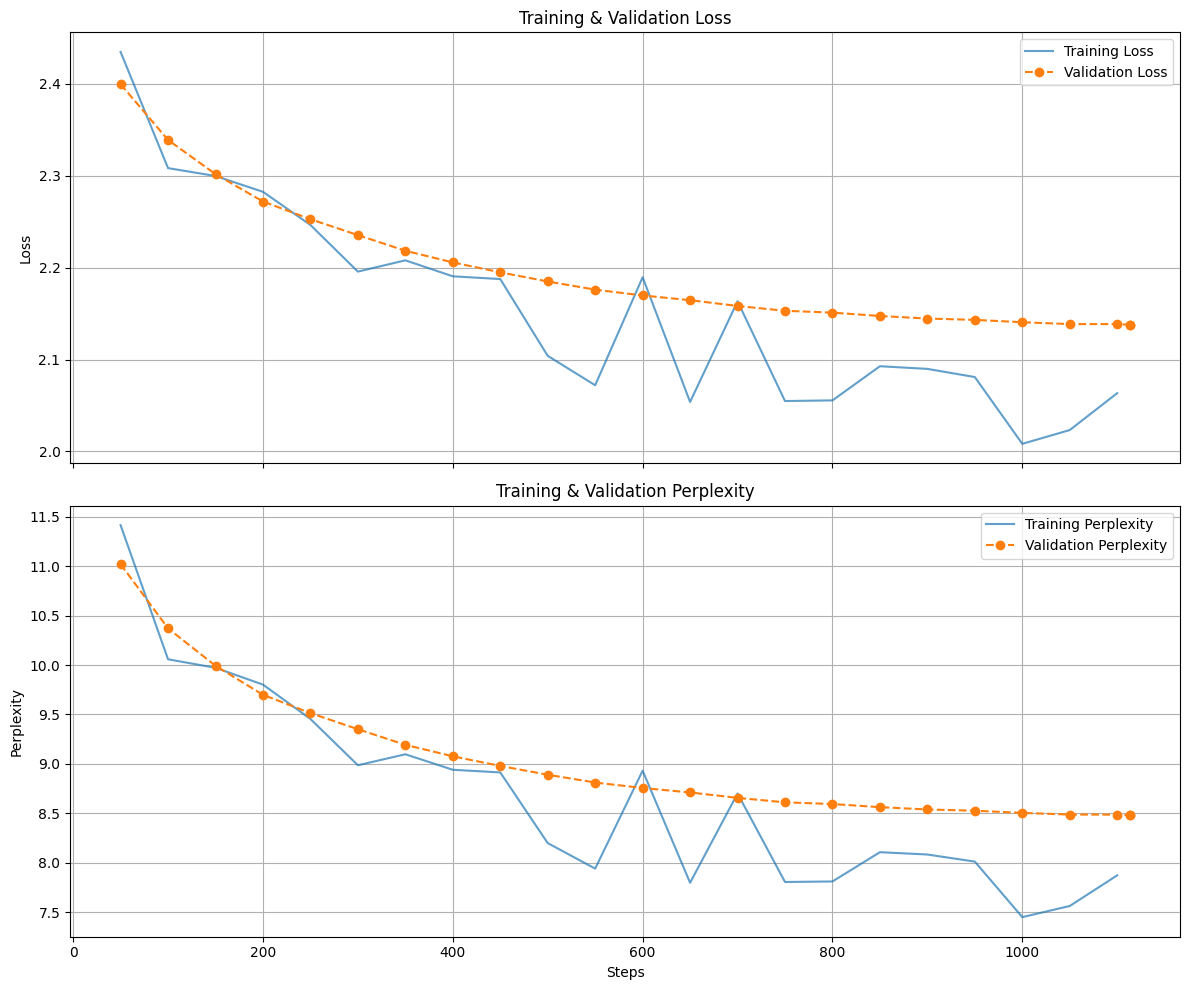

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

train_loss_steps = [data[0] for data in metrics_callback.metrics['train_loss']]
train_loss_values = [data[1] for data in metrics_callback.metrics['train_loss']]

eval_loss_steps = [data[0] for data in metrics_callback.metrics['eval_loss']]
eval_loss_values = [data[1] for data in metrics_callback.metrics['eval_loss']]

ax1.plot(train_loss_steps, train_loss_values, label='Training Loss', alpha=0.7)
ax1.plot(eval_loss_steps, eval_loss_values, label='Validation Loss', alpha=0.7)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True)

train_ppl_steps = [data[0] for data in metrics_callback.metrics['train_perplexity']]
train_ppl_values = [data[1] for data in metrics_callback.metrics['train_perplexity']]

eval_ppl_steps = [data[0] for data in metrics_callback.metrics['eval_perplexity']]
eval_ppl_values = [data[1] for data in metrics_callback.metrics['eval_perplexity']]

ax2.plot(train_ppl_steps, train_ppl_values, label='Training Perplexity', alpha=0.7)
ax2.plot(eval_ppl_steps, eval_ppl_values, label='Validation Perplexity', alpha=0.7)
ax2.set_xlabel('Steps')
ax2.set_ylabel('Perplexity')
ax2.set_title('Training & Validation Perplexity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Save Model

In [ ]:
print("Pelatihan selesai. Menyimpan model final.")
trainer.save_model(os.path.join(OUTPUT_DIR, "final_model"))
tokenizer.save_pretrained(os.path.join(OUTPUT_DIR, "final_model"))

Pelatihan selesai. Menyimpan model final.


('/content/drive/MyDrive/cpt_model_checkpoints/final_model/tokenizer_config.json',
 '/content/drive/MyDrive/cpt_model_checkpoints/final_model/special_tokens_map.json',
 '/content/drive/MyDrive/cpt_model_checkpoints/final_model/chat_template.jinja',
 '/content/drive/MyDrive/cpt_model_checkpoints/final_model/vocab.json',
 '/content/drive/MyDrive/cpt_model_checkpoints/final_model/merges.txt',
 '/content/drive/MyDrive/cpt_model_checkpoints/final_model/added_tokens.json',
 '/content/drive/MyDrive/cpt_model_checkpoints/final_model/tokenizer.json')